# Which club has the best staff?
Gabriel Lam

## Intent

Study player data from Division 1 European League* players from the last 5 Years. Analyze changes in player stats and value. Rank the clubs according to best increase in statistics of a player. Graphically represent the scores for the test set.

1. Does an increase in player spending create an increase in team rating?
2. Given a player’s age and starting skill level, what is the expected improvement?
3. How does a player’s ‘potential’ affect their future rating?

Details :
Sofifa Id, URL, Wage, Salary, Name, Real face, URL variables cannot be used during the prediction or learning.

1. Assign a score to all clubs out of 100, and represent it in an appropriate visualization. With 100 being the highest
2. For the test set, your model will be scored using MSE against the average of all models of the class. (Score = MSE( Your Values , Average of all models values))

The test set is as follows for this problem statement (Division 1 European League):
League =
- Premier League - English Premier League
- Bundesliga German 1. Bundesliga
- Ligue 1 French Ligue 1
- La Liga Spain Primera Division
- Serie A Italian Serie A



In [2]:
# imports and setups

import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import numpy as np
import re
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Importing the Data

This pulls the necessary training and test data for initial work. This is based upon the player_data_cleaning notebook, which outputs these modified data files.

In [3]:
# import the cleaned data for FIFA19
p15_df = pd.read_csv('cleaned_data/players_15.csv')
p16_df = pd.read_csv('cleaned_data/players_16.csv')
p17_df = pd.read_csv('cleaned_data/players_17.csv')
p18_df = pd.read_csv('cleaned_data/players_18.csv')
p19_df = pd.read_csv('cleaned_data/players_19.csv')
p20_df = pd.read_csv('cleaned_data/players_20.csv')
league_df = pd.read_csv('cleaned_data/teams_and_leagues.csv')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Reviewing changes

Analyze changes in player stats and value. Rank the clubs according to best increase in statistics of a player. Graphically represent the scores for the test set.

To Do:
1. Categorize train and test sets
2. Find increase in statistics / values over 5 years
3. Use this ranking to assign score to each team
4. Predict the rankings for the test set


In [4]:
test_clubs = ["English Premier League ","Spain Primera Division ", "German 1. Bundesliga ","French Ligue 1 ","Italian Serie A"]

test_col = league_df[league_df["league_name"].isin(test_clubs)]["team"]
train_col = league_df[~league_df["league_name"].isin(test_clubs)]["team"]

## Selecting columns for train / test split:

Using a target set of columns to ensure that the data is not too convoluted during the learning / prediction process:

In [5]:
target_cols = ["overall","potential","value_eur","wage_eur","pace","shooting","dribbling",
               "defending","physic", "gk_diving","gk_handling","gk_kicking",
               "gk_reflexes", "gk_speed","gk_positioning"]

# target_cols = ["overall","potential","value_eur","pace","shooting","dribbling",
#                "defending","physic", "gk_diving","gk_handling","gk_kicking",
#                "gk_reflexes", "gk_speed","gk_positioning","attacking_crossing",
#               "attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
#               "attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy",
#                "skill_long_passing","skill_ball_control","movement_acceleration",
#               "movement_sprint_speed","movement_agility","movement_reactions","movement_balance",
#               "power_shot_power","power_jumping","power_stamina", "power_strength","power_long_shots"]

In [6]:
data_test_15 = p15_df[p15_df["club"].isin(test_col)][target_cols]
data_train_15 = p15_df[~p15_df["club"].isin(test_col)][target_cols]

data_test_16 = p16_df[p16_df["club"].isin(test_col)][target_cols]
data_train_16 = p16_df[~p16_df["club"].isin(test_col)][target_cols]

data_test_17 = p17_df[p17_df["club"].isin(test_col)][target_cols]
data_train_17 = p17_df[~p17_df["club"].isin(test_col)][target_cols]

data_test_18 = p18_df[p18_df["club"].isin(test_col)][target_cols]
data_train_18 = p18_df[~p18_df["club"].isin(test_col)][target_cols]

data_test_19 = p19_df[p19_df["club"].isin(test_col)][target_cols]
data_train_19 = p19_df[~p19_df["club"].isin(test_col)][target_cols]

data_test_20 = p20_df[p20_df["club"].isin(test_col)][target_cols]
data_train_20 = p20_df[~p20_df["club"].isin(test_col)][target_cols]

## Initial EDA:

Due to lack of data in player value in FIFA 15, I will not be including that dataset in the analysis of player statistics over the last 5 years.

In addition, I will focus on using the "overall" statistic growth first as a measure of how a club is ranked. Extract the team rating by averaging out the rating of all the players in the team. The value of the team will therefore be the sum of the total value of the players, and this will allow us to visualize the response of the change of rating with regards to a change of value.

**For each team:
    For each player:
        Find the overall statistic over last 5 years
        Find the value statistic over the last 5 years
        find the average increase to determine growth of overall
        find the average increase to determine growth of value
    average growth values and overall values for the entire team
    
find all growths for all teams

scale the distribution to 100 to see how the teams fare compared to the one with the highest growth**



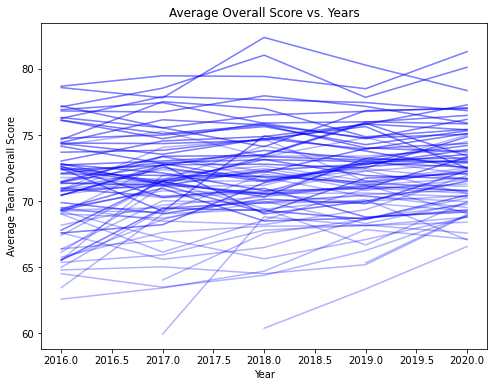

In [7]:
plt.figure(figsize=(8,6))
rate_growth_list = []
for team in test_col:
    year_list = np.arange(2016,2021)
    
    rating16 = p16_df.loc[p16_df["club"] == team]["overall"].mean()
    rating17 = p17_df.loc[p17_df["club"] == team]["overall"].mean()
    rating18 = p18_df.loc[p18_df["club"] == team]["overall"].mean()
    rating19 = p19_df.loc[p19_df["club"] == team]["overall"].mean()
    rating20 = p20_df.loc[p20_df["club"] == team]["overall"].mean()
    
    rating_list = [rating16,rating17,rating18,rating19,rating20]
    
    average = ((rating17-rating16)+(rating18-rating17)+(rating19-rating18)+(rating19-rating20))/4
    
    plt.plot(year_list,rating_list, label = team,linewidth = 1.5,alpha = 0.3,color = "b")
    
    rate_growth_list.append(np.mean(average))
    
# plt.legend()
plt.ylabel("Average Team Overall Score")
plt.xlabel("Year")
plt.title("Average Overall Score vs. Years")
plt.show()

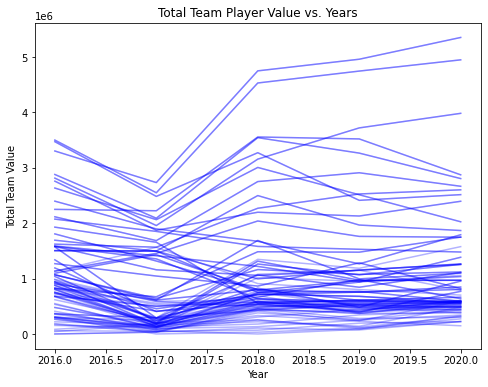

In [8]:
plt.figure(figsize=(8,6))

wage_growth_list = []

for team in test_col:
    year_list = np.arange(2016,2021)
    
    wage16 = p16_df.loc[p16_df["club"] == team]["wage_eur"].sum()
    wage17 = p17_df.loc[p17_df["club"] == team]["wage_eur"].sum()
    wage18 = p18_df.loc[p18_df["club"] == team]["wage_eur"].sum()
    wage19 = p19_df.loc[p19_df["club"] == team]["wage_eur"].sum()
    wage20 = p20_df.loc[p20_df["club"] == team]["wage_eur"].sum()
    
    wage_list = [wage16,wage17,wage18,wage19,wage20]
    plt.plot(year_list,wage_list, label = team,linewidth = 1.5,alpha = .3,color = "b")
    
    average = ((wage17-wage16)+(wage18-wage17)+(wage19-wage18)+(wage19-wage20))/4
    wage_growth_list.append(np.mean(average))
    
# plt.legend()
plt.ylabel("Total Team Value")
plt.xlabel("Year")
plt.title("Total Team Player Value vs. Years")
plt.show()

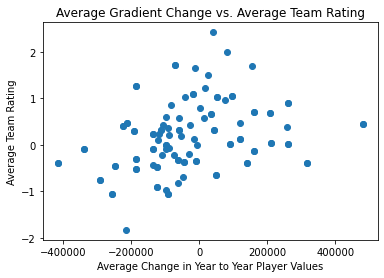

In [9]:
plt.scatter(wage_growth_list,rate_growth_list)
plt.title("Average Gradient Change vs. Average Team Rating")
plt.ylabel("Average Team Rating")
plt.xlabel("Average Change in Year to Year Player Values")
plt.show()

potential:
find potential in 2015
find overall in 2015
predict overall 2016

repeat for all years

predictor = potential
response = next year's overall



predictors:
total team value
total team wages

response:
average team rating

In [10]:
df_1 = league_df.copy(deep=True)

wage16_list = []
wage17_list = []
wage18_list = []
wage19_list = []
wage20_list = []

value16_list = []
value17_list = []
value18_list = []
value19_list = []
value20_list = []

rating16_list = []
rating17_list = []
rating18_list = []
rating19_list = []
rating20_list = []

for team in league_df["team"]:
    wage16 = p16_df.loc[p16_df["club"] == team]["wage_eur"].sum()
    wage17 = p17_df.loc[p17_df["club"] == team]["wage_eur"].sum()
    wage18 = p18_df.loc[p18_df["club"] == team]["wage_eur"].sum()
    wage19 = p19_df.loc[p19_df["club"] == team]["wage_eur"].sum()
    wage20 = p20_df.loc[p20_df["club"] == team]["wage_eur"].sum()
    
    wage16_list.append(wage16)
    wage17_list.append(wage17)
    wage18_list.append(wage18)
    wage19_list.append(wage19)
    wage20_list.append(wage20)
    
    value16 = p16_df.loc[p16_df["club"] == team]["value_eur"].sum()
    value17 = p17_df.loc[p17_df["club"] == team]["value_eur"].sum()
    value18 = p18_df.loc[p18_df["club"] == team]["value_eur"].sum()
    value19 = p19_df.loc[p19_df["club"] == team]["value_eur"].sum()
    value20 = p20_df.loc[p20_df["club"] == team]["value_eur"].sum()
    
    value16_list.append(value16)
    value17_list.append(value17)
    value18_list.append(value18)
    value19_list.append(value19)
    value20_list.append(value20)
    
    rating16 = p16_df.loc[p16_df["club"] == team]["overall"].mean()
    rating17 = p17_df.loc[p17_df["club"] == team]["overall"].mean()
    rating18 = p18_df.loc[p18_df["club"] == team]["overall"].mean()
    rating19 = p19_df.loc[p19_df["club"] == team]["overall"].mean()
    rating20 = p20_df.loc[p20_df["club"] == team]["overall"].mean()

    rating16_list.append(rating16)
    rating17_list.append(rating17)
    rating18_list.append(rating18)
    rating19_list.append(rating19)
    rating20_list.append(rating20)
    
df_1["total team wages 2016"] = wage16_list
df_1["total team wages 2017"] = wage17_list
df_1["total team wages 2018"] = wage18_list
df_1["total team wages 2019"] = wage19_list
df_1["total team wages 2020"] = wage20_list

df_1["total team value 2016"] = value16_list
df_1["total team value 2017"] = value17_list
df_1["total team value 2018"] = value18_list
df_1["total team value 2019"] = value19_list
df_1["total team value 2020"] = value20_list

df_1["avg team rating 2016"] = rating16_list
df_1["avg team rating 2017"] = rating17_list
df_1["avg team rating 2018"] = rating18_list
df_1["avg team rating 2019"] = rating19_list
df_1["avg team rating 2020"] = rating20_list

df_1_test = df_1[df_1["league_name"].isin(test_clubs)].drop(["Unnamed: 0"],axis = 1)
df_1_train = df_1[~df_1["league_name"].isin(test_clubs)].drop(["Unnamed: 0"],axis = 1)



In [11]:
# df_1_test = df_1[df_1["league_name"].isin(test_clubs)].drop(["Unnamed: 0"])
# df_1_train = df_1[~df_1["league_name"].isin(test_clubs)]

Xtrain_16 = df_1_train[["total team wages 2016","total team value 2016"]]
Xtrain_17 = df_1_train[["total team wages 2017","total team value 2017"]]
Xtrain_18 = df_1_train[["total team wages 2018","total team value 2018"]]
Xtrain_19 = df_1_train[["total team wages 2019","total team value 2019"]]
Xtrain_20 = df_1_train[["total team wages 2020","total team value 2020"]]

ytrain_16 = df_1_train["avg team rating 2016"].fillna(0)
ytrain_17 = df_1_train["avg team rating 2017"].fillna(0)
ytrain_18 = df_1_train["avg team rating 2018"].fillna(0)
ytrain_19 = df_1_train["avg team rating 2019"].fillna(0)
ytrain_20 = df_1_train["avg team rating 2020"].fillna(0)



In [12]:
Xtest_16 = df_1_test[["total team wages 2016","total team value 2016"]]
ytest_16 = df_1_test["avg team rating 2016"].fillna(0)

Xtest_17 = df_1_test[["total team wages 2017","total team value 2017"]]
ytest_17 = df_1_test["avg team rating 2017"].fillna(0)

Xtest_18 = df_1_test[["total team wages 2018","total team value 2018"]]
ytest_18 = df_1_test["avg team rating 2018"].fillna(0)

Xtest_19 = df_1_test[["total team wages 2019","total team value 2019"]]
ytest_19 = df_1_test["avg team rating 2019"].fillna(0)

Xtest_20 = df_1_test[["total team wages 2020","total team value 2020"]]
ytest_20 = df_1_test["avg team rating 2020"].fillna(0)

In [13]:
scalerX = StandardScaler()
scalerX.fit(Xtrain_20)

Xtrain_16_scaled = scalerX.transform(Xtrain_16)
Xtrain_17_scaled = scalerX.transform(Xtrain_17)
Xtrain_18_scaled = scalerX.transform(Xtrain_18)
Xtrain_19_scaled = scalerX.transform(Xtrain_19)
Xtrain_20_scaled = scalerX.transform(Xtrain_20)

Xtest_16_scaled = scalerX.transform(Xtest_16)
Xtest_17_scaled = scalerX.transform(Xtest_17)
Xtest_18_scaled = scalerX.transform(Xtest_18)
Xtest_19_scaled = scalerX.transform(Xtest_19)
Xtest_20_scaled = scalerX.transform(Xtest_20)


In [16]:
depths = range(20, 50, 2)
scores16 = []
scores17 = []
scores18 = []
scores19 = []
scores20 = []
mean_scores = []

for depth in depths:
    print(f'Evaluating depth of {depth}...')
    dec_tree = DecisionTreeRegressor(max_depth=depth)
    bagger = BaggingRegressor(dec_tree, n_estimators=100)
    result16 = cross_validate(bagger, Xtrain_16_scaled, ytrain_16.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score16 = np.abs(np.mean(result16["test_score"]))
    scores16.append(score16)
    print(f'Saved score for 2016 of {score16:.5f}.')
    
    result17 = cross_validate(bagger, Xtrain_17_scaled, ytrain_17.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score17 = np.abs(np.mean(result17["test_score"]))
    scores17.append(score17)
    print(f'Saved score for 2017 of {score17:.5f}.')
    
    result18 = cross_validate(bagger, Xtrain_18_scaled, ytrain_18.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score18 = np.abs(np.mean(result18["test_score"]))
    scores18.append(score18)
    print(f'Saved score for 2018 of {score18:.5f}.')
    
    result19 = cross_validate(bagger, Xtrain_19_scaled, ytrain_19.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score19 = np.abs(np.mean(result19["test_score"]))
    scores19.append(score19)
    print(f'Saved score for 2019 of {score19:.5f}.')
    
    result20 = cross_validate(bagger, Xtrain_20_scaled, ytrain_20.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score20 = np.abs(np.mean(result20["test_score"]))
    scores20.append(score20)
    print(f'Saved score for 2020 of {score20:.5f}.')
    
    mean_scores.append(np.mean([score16,score17,score18,score19,score20]))

Evaluating depth of 20...
Saved score for 2016 of 3.97899.
Saved score for 2017 of 1.01395.
Saved score for 2018 of 1.27189.
Saved score for 2019 of 1.38331.
Saved score for 2020 of 1.67653.
Evaluating depth of 22...
Saved score for 2016 of 3.50265.
Saved score for 2017 of 1.05304.
Saved score for 2018 of 1.26175.
Saved score for 2019 of 1.40127.
Saved score for 2020 of 1.68568.
Evaluating depth of 24...
Saved score for 2016 of 3.36918.
Saved score for 2017 of 1.04782.
Saved score for 2018 of 1.26061.
Saved score for 2019 of 1.40576.
Saved score for 2020 of 1.65913.
Evaluating depth of 26...
Saved score for 2016 of 3.79090.
Saved score for 2017 of 1.05994.
Saved score for 2018 of 1.27980.
Saved score for 2019 of 1.41042.
Saved score for 2020 of 1.69580.
Evaluating depth of 28...
Saved score for 2016 of 3.52927.
Saved score for 2017 of 1.06970.
Saved score for 2018 of 1.30499.
Saved score for 2019 of 1.35903.
Saved score for 2020 of 1.61871.
Evaluating depth of 30...
Saved score for 201

In [17]:

min_idx = np.argmin(mean_scores)
best_depth = depths[min_idx]
best_score = mean_scores[min_idx]

print(f'The best depth was {best_depth} with a score of {best_score:.5f}.')

The best depth was 40 with a score of 1.70433.


In [18]:
dec_tree = DecisionTreeRegressor(max_depth=best_depth)
bagger16 = BaggingRegressor(dec_tree, n_estimators=100)
bagger16.fit(Xtrain_16_scaled, ytrain_16)

bagger17 = BaggingRegressor(dec_tree, n_estimators=100)
bagger17.fit(Xtrain_17_scaled, ytrain_17)

bagger18 = BaggingRegressor(dec_tree, n_estimators=100)
bagger18.fit(Xtrain_18_scaled, ytrain_18)

bagger19 = BaggingRegressor(dec_tree, n_estimators=100)
bagger19.fit(Xtrain_19_scaled, ytrain_19)

bagger20 = BaggingRegressor(dec_tree, n_estimators=100)
bagger20.fit(Xtrain_20_scaled, ytrain_20)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=40),
                 n_estimators=100)

In [20]:
accuracy16 = bagger16.score(Xtest_16_scaled, ytest_16)
accuracy17 = bagger17.score(Xtest_17_scaled, ytest_17)
accuracy18 = bagger18.score(Xtest_18_scaled, ytest_18)
accuracy19 = bagger19.score(Xtest_19_scaled, ytest_19)
accuracy20 = bagger20.score(Xtest_20_scaled, ytest_20)
# ytest_20_pred = bagger.predict(Xtest_20_scaled)
# accuracy = accuracy_score(ytest_20, ytest_20_pred)
print(f'The optimized and scaled tree results in {accuracy16:.5f} accurate on the FIFA16 set.')
print(f'The optimized and scaled tree results in {accuracy17:.5f} accurate on the FIFA17 set.')
print(f'The optimized and scaled tree results in {accuracy18:.5f} accurate on the FIFA18 set.')
print(f'The optimized and scaled tree results in {accuracy19:.5f} accurate on the FIFA19 set.')
print(f'The optimized and scaled tree results in {accuracy20:.5f} accurate on the FIFA20 set.')

The optimized and scaled tree results in 0.96822 accurate on the FIFA16 set.
The optimized and scaled tree results in 0.94237 accurate on the FIFA17 set.
The optimized and scaled tree results in 0.91491 accurate on the FIFA18 set.
The optimized and scaled tree results in 0.42778 accurate on the FIFA19 set.
The optimized and scaled tree results in 0.77404 accurate on the FIFA20 set.
